# Building a Trump Tweet Classifier with Keras

#### Author: Dr. James Allen-Robertson , Dept. of Sociology University of Essex UK

The data for this project can be obtained from https://github.com/bpb27/trump_tweet_data_archive - specifically you will need the condensed archive files for 2015, 2016 and 2017. Once downloaded ensure this notebook file and the archives are in the same folder, or adjust the paths accordingly.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.concat([pd.read_json('condensed_2016.json'), pd.read_json('condensed_2017.json'), pd.read_json('condensed_2015.json')])
# df.source = pd.Categorical(df.source)

In [3]:
df = df[~df.text.str.startswith('RT')]
df.reset_index(inplace=True)


In [4]:
df.set_index('created_at', inplace=True)
df.sort_index(inplace=True)


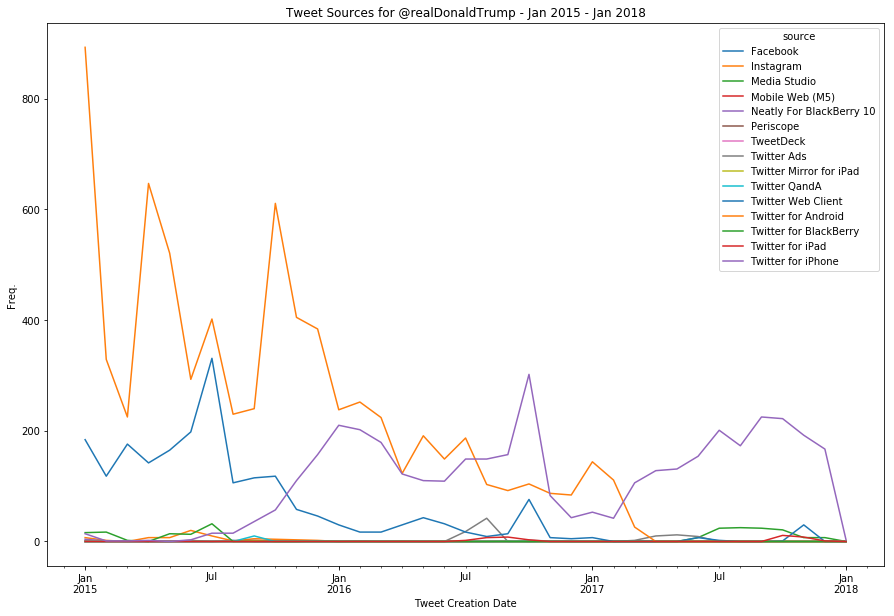

In [5]:
df.pivot_table(index='created_at',columns=['source'],values='index', aggfunc='count').resample('M').count().plot(figsize=(15,10), title='Tweet Sources for @realDonaldTrump - Jan 2015 - Jan 2018')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Freq.')
plt.savefig('1_tweet_sources.png')

In [6]:
top3_sources = df.source.value_counts().index[:3].tolist()

In [7]:
top2_sources = ['Twitter for Android', 'Twitter for iPhone']

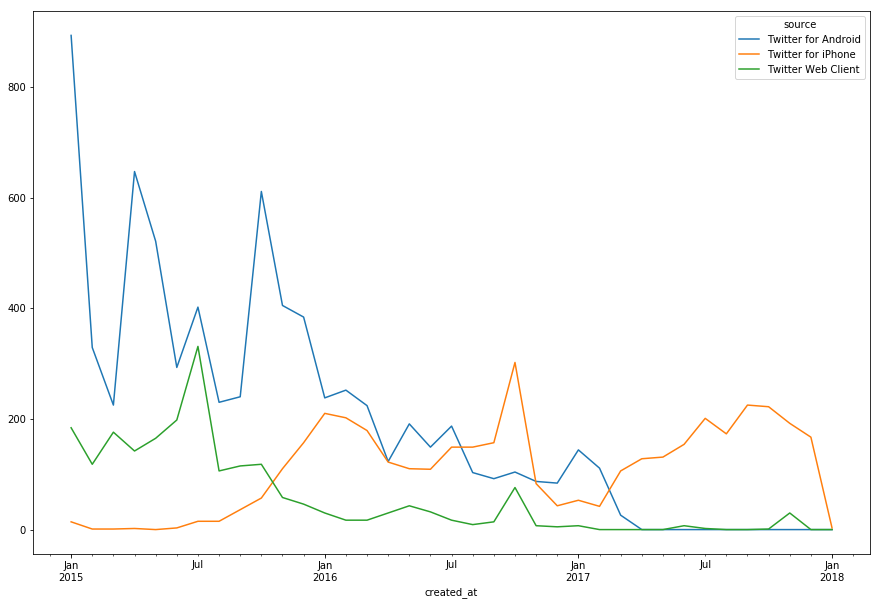

In [8]:
df.pivot_table(index='created_at',columns=['source'],values='index', aggfunc='count').loc[:,top3_sources].resample('M').count().plot(figsize=(15,10))

# Pre-Iphone

When did Trump switch to iPhone?

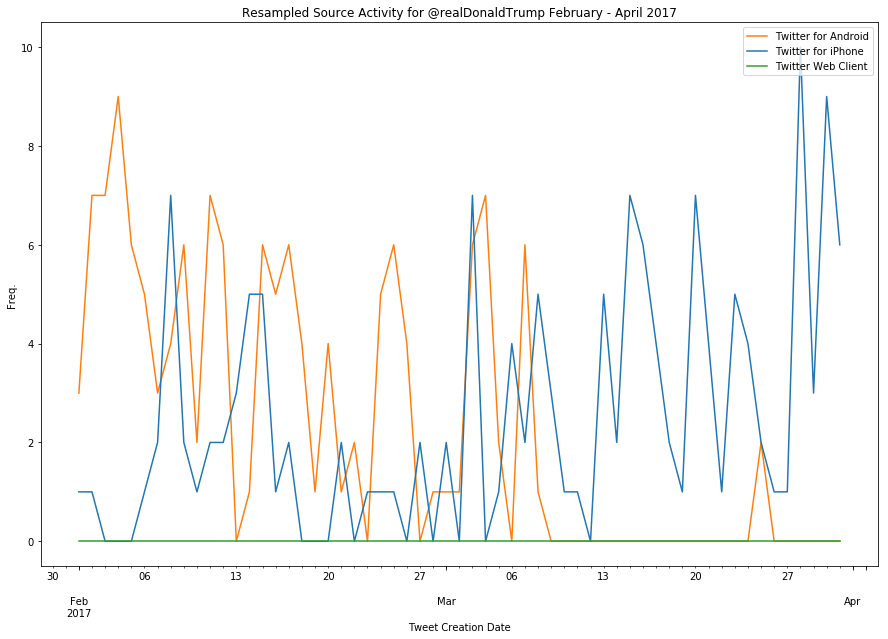

In [9]:
ax = df.pivot_table(index='created_at',columns=['source'],values='index', aggfunc='count').loc['February 2017':'March 2017',top3_sources].resample('D').count().plot(figsize=(15,10))


# Ensure that Android stays Orange
for ax in plt.gcf().axes:
    ax.get_lines()[1].set_color("#1f77b4")
    ax.get_lines()[0].set_color("#ff7f0e")
    ax.get_lines()[2].set_color("#2ca02c")

plt.legend(loc='upper right')
plt.title('Resampled Source Activity for @realDonaldTrump February - April 2017')
plt.xlabel('Tweet Creation Date')
plt.ylabel('Freq.')
plt.savefig('android_dark_date.png')

In [10]:
pre_iphone_data = df.loc['June 2015':'08 March 2017'].copy()

In [11]:
post_iphone_data = df.loc['09 March 2017':].copy()

# Training a Trump Classifier with Keras

In [12]:
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split

Using TensorFlow backend.
/Users/James/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Fit a TFIDF Model to the Whole Corpus of Text

In [50]:
tfidf = TfidfVectorizer(max_df=0.95,min_df=0.02)

In [51]:
tfidf.fit(df.text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=0.02,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [15]:
n_cols = len(tfidf.get_feature_names())

In [16]:
def build_model(input_shape, output_shape, layers=2, nodes=100):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_shape = (input_shape,)))
    for x in range(layers):
        model.add(Dense(nodes, activation='relu'))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy','mean_squared_error'])
    return model

### Designate all Trump Tweets as Target 1, and all others as Target 0

In [17]:
pre_iphone_data['targets'] = pre_iphone_data.source.apply(lambda x: 1 if x == 'Twitter for Android' else 0)
post_iphone_data['targets'] = post_iphone_data.source.apply(lambda x: 1 if x == 'Twitter for Android' else 0)
pre_iphone_data.targets.value_counts()

1    4678
0    3801
Name: targets, dtype: int64

### Evaluate a variety of models for highest accuracy

The model evaluator uses Stratified K Fold to slice up the data into 10 sets of testing and training data. Each model of x layers and y nodes per layer is then tested with every set of training and testing data. Accuracy scores are aggregated for a mean score to evaluate the quality of that neural network model.

In [18]:
early_stopping_monitor = EarlyStopping(patience=2,monitor='acc')

In [19]:
def model_evaluator(X, Y, layers=[1,2,3], nodes=[100,200,500], kfold_splits=10, add_to_scores=[], add_to_labels=[]):
    from sklearn.model_selection import StratifiedKFold
    kfold = StratifiedKFold(n_splits=kfold_splits, shuffle=True, random_state=1)
    top_score = 0
    idx=0
    for layer in layers:
        for node_num in nodes:
            sub_score = []
            
            for train, test in kfold.split(X, Y):
                model = build_model(n_cols, 2,nodes=node_num, layers=layer)
                model.fit(X[train],to_categorical(Y[train]), epochs=50, callbacks=[early_stopping_monitor],verbose=0)
                sub_score.append(model.evaluate(X[test], to_categorical(Y[test]))[1] *100)

            score = pd.np.mean(sub_score)
            score_name = model.metrics_names[1]

            print(f'{layer},{node_num} - {score_name}: {score.round(2)}%')
            
            add_to_labels.append(f'M{idx:02}-{layer},{node_num}')
            add_to_scores.append(score)
            idx += 1
            if score > top_score:
                print(f'{layer},{node_num} is the current top model!')
                top_score = score
    return add_to_scores, add_to_labels

In [20]:
layers = [1,2,3,4]
nodes = [500,1000,2000]

from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
X = tfidf.transform(pre_iphone_data.text).toarray()
Y = pd.np.array(pre_iphone_data.targets)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
score_history_scores = []
score_history_labels = []


In [21]:
import os
from sklearn.externals import joblib

if not os.path.exists('scores.pkl'):
    new_scores, new_labels = model_evaluator(X,Y, layers=layers, nodes=nodes,add_to_scores=score_history_scores, add_to_labels=score_history_labels)
    joblib.dump(new_scores,'scores.pkl')
    joblib.dump(new_labels,'labels.pkl')
else:
    new_scores = joblib.load('scores.pkl')
    new_labels = joblib.load('labels.pkl')

#### We then plot the average score of 10 different subsets of the data for each model.

In [22]:
data = pd.DataFrame([new_scores,new_labels], index=['scores','labels']).transpose()

In [23]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

/Users/James/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
/Users/James/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


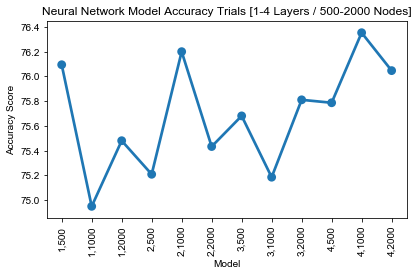

In [24]:
# plt.figure(figsize=(10,10))
sns.pointplot(data=data,x='labels',y='scores')
sns.set()
plt.xticks(rotation=90)
# plt.tight_layout()
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Neural Network Model Accuracy Trials [1-4 Layers / 500-2000 Nodes]')
plt.savefig('accuracy_scores.jpg', dpi=200, )

4 Layers of 1000 Nodes is our top model though 2,1000 and even 1,500 provide similar accuracy

In [25]:
train, test = train_test_split(pre_iphone_data, test_size=0.3)

In [26]:
final_model = build_model(layers=2, nodes=1000,input_shape=n_cols,output_shape=2)

In [27]:
final_model.fit(tfidf.transform(train.text),to_categorical(train.targets), epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
5935/5935 [==============================] - 3s 478us/step - loss: 0.5114 - acc: 0.7574 - mean_squared_error: 0.1692
Epoch 2/50
5935/5935 [==============================] - 3s 464us/step - loss: 0.4400 - acc: 0.7993 - mean_squared_error: 0.1415
Epoch 3/50
5935/5935 [==============================] - 3s 467us/step - loss: 0.4043 - acc: 0.8224 - mean_squared_error: 0.1286
Epoch 4/50
5935/5935 [==============================] - 3s 475us/step - loss: 0.3668 - acc: 0.8404 - mean_squared_error: 0.1147
Epoch 5/50
5935/5935 [==============================] - 3s 469us/step - loss: 0.3185 - acc: 0.8667 - mean_squared_error: 0.0976
Epoch 6/50
5935/5935 [==============================] - 3s 478us/step - loss: 0.2604 - acc: 0.8915 - mean_squared_error: 0.0789
Epoch 7/50
5935/5935 [==============================] - 3s 490us/step - loss: 0.2047 - acc: 0.9198 - mean_squared_error: 0.0601
Epoch 8/50
5935/5935 [==============================] - 3s 475us/step - loss: 0.1548 - acc: 0.9402 - mea

In [28]:
final_model.evaluate(tfidf.transform(test.text), to_categorical(test.targets))

2544/2544 [==============================] - 0s 80us/step


[1.3887065667776193, 0.73231132075471694, 0.2337577647570544]

#### Here we see the chosen top model, when given all the training data is ~76% accurate at identifying Trump Tweets

We feed the model the test data to provide further training before utilising it for prediction.

In [29]:
final_model.fit(tfidf.transform(test.text),y=to_categorical(test.targets),epochs=50, callbacks=[early_stopping_monitor])

Epoch 1/50
2544/2544 [==============================] - 1s 464us/step - loss: 0.5457 - acc: 0.7866 - mean_squared_error: 0.1563
Epoch 2/50
2544/2544 [==============================] - 1s 460us/step - loss: 0.3850 - acc: 0.8302 - mean_squared_error: 0.1224
Epoch 3/50
2544/2544 [==============================] - 1s 459us/step - loss: 0.3344 - acc: 0.8542 - mean_squared_error: 0.1048
Epoch 4/50
2544/2544 [==============================] - 1s 445us/step - loss: 0.2754 - acc: 0.8852 - mean_squared_error: 0.0841
Epoch 5/50
2544/2544 [==============================] - 1s 476us/step - loss: 0.2007 - acc: 0.9245 - mean_squared_error: 0.0580
Epoch 6/50
2544/2544 [==============================] - 1s 477us/step - loss: 0.1291 - acc: 0.9556 - mean_squared_error: 0.0356
Epoch 7/50
2544/2544 [==============================] - 1s 479us/step - loss: 0.0645 - acc: 0.9819 - mean_squared_error: 0.0157
Epoch 8/50
2544/2544 [==============================] - 1s 471us/step - loss: 0.0341 - acc: 0.9898 - mea

In [30]:
final_model.evaluate(tfidf.transform(pre_iphone_data.text), to_categorical(pre_iphone_data.targets))

8479/8479 [==============================] - 1s 68us/step


[0.3375819677302267, 0.92239650902932002, 0.064859987866943802]

... and see it is 92% accurate, however this is on the data it has already seen so this measure cannot be taken as accuracy on unseen data. The 77% is much closer to the model's accuracy.

In [108]:
final_model.save('Trump_tweet_classifier.bin')

# Finding Trump

We make our predictions on the tweets after the iPhone was introduced... 

In [31]:
from keras.models import load_model

In [32]:
final_model = load_model('Trump_tweet_classifier.bin')

In [33]:
predictions = final_model.predict(tfidf.transform(post_iphone_data.text))

In [34]:
post_iphone_data['prediction'] = predictions.argmax(axis=1)

In [35]:
post_iphone_data['prediction_score'] = predictions.max(axis=1)

In [36]:
post_iphone_data.prediction.value_counts()

1    997
0    896
Name: prediction, dtype: int64

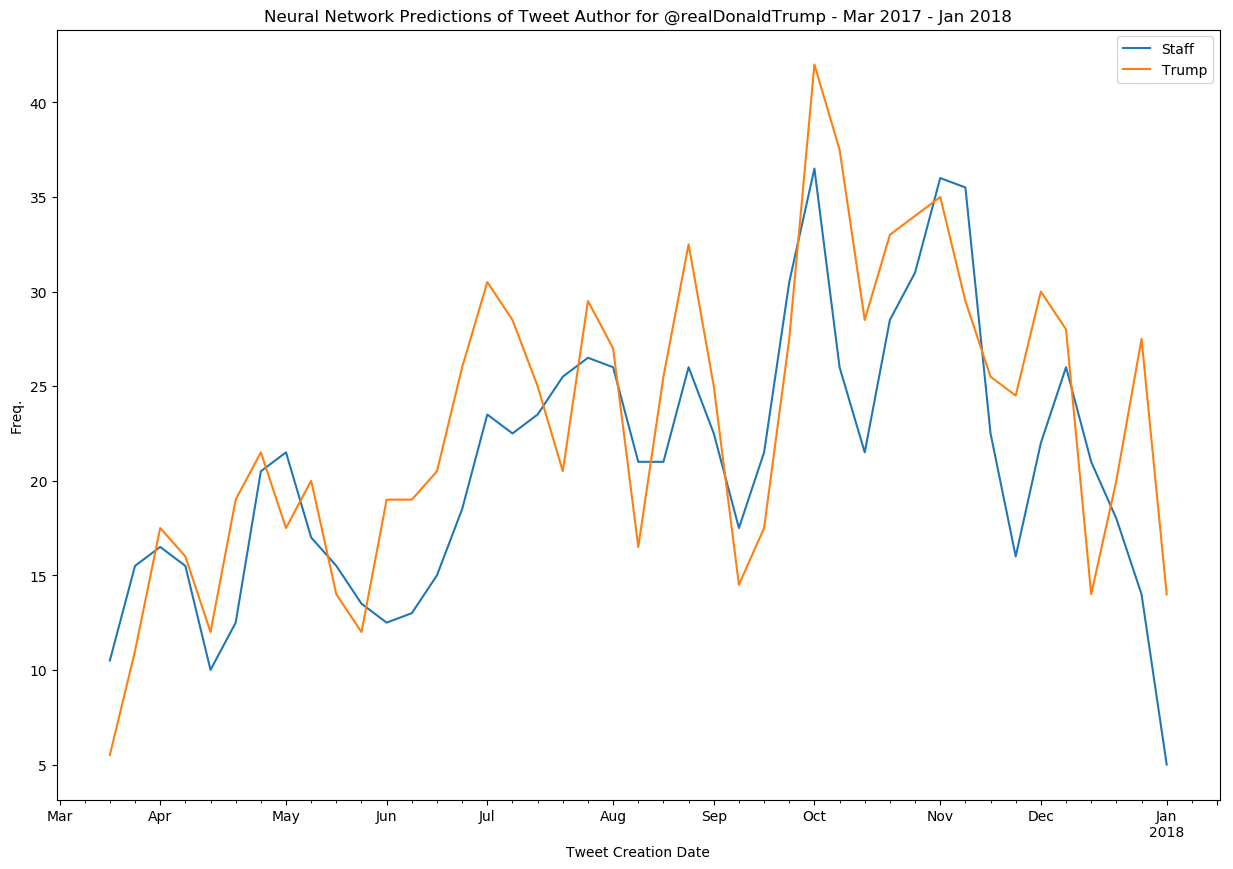

In [144]:
sns.reset_orig()
ax = post_iphone_data.pivot_table(index='created_at',columns=['prediction'],values='index', aggfunc='count').resample('W').count().rolling(2).mean().plot(figsize=(15,10))
ax.legend(['Staff', 'Trump'])
plt.xlabel('Tweet Creation Date')
plt.ylabel('Freq.')
plt.title('Neural Network Predictions of Tweet Author for @realDonaldTrump - Mar 2017 - Jan 2018')
plt.savefig('predictions.png', dpi=400)

... and it is now down to human evaluation to decide on how succesful the model is.

In [37]:
sample_trump_one = post_iphone_data[post_iphone_data.prediction == 1].sample(1)

sample_staff_one = post_iphone_data[post_iphone_data.prediction == 0].sample(1)
print('TRUMP')
print(f'Confidence: {sample_trump_one["prediction_score"].values[0]:.3f}%')
print(sample_trump_one['text'].values[0])
print()
print('STAFF')
print(f'Confidence: {sample_staff_one["prediction_score"].values[0]:.3f}%')
print(sample_staff_one['text'].values[0])

TRUMP
Confidence: 0.937%
#StandForOurAnthem

STAFF
Confidence: 0.998%
Just returned to Bedminster, NJ from Camp David. GREAT meeting on National Security, the Border and the Military! #MAGA🇺🇸 https://t.co/Hjmcnnse9j


In [60]:
sample_trump = post_iphone_data[post_iphone_data.prediction == 1].sample(10)[['source','text','prediction_score']]
sample_staff = post_iphone_data[post_iphone_data.prediction == 0].sample(10)[['source','text','prediction_score']]

In [61]:
sample_trump.style.set_properties(subset=['text'], **{'width': '400'})


,source,text,prediction_score
created_at,,,
2017-11-22 11:51:22,Twitter for iPhone,Will be having meetings and working the phones from the Winter White House in Florida (Mar-a-Lago). Stock Market hit new Record High yesterday - $5.5 trillion gain since E. Many companies coming back to the U.S. Military building up and getting very strong.,0.99747
2017-04-17 12:07:16,Twitter for iPhone,"""The first 90 days of my presidency has exposed the total failure of the last eight years of foreign policy!"" So true. @foxandfriends",0.976732
2017-10-16 12:21:49,Twitter for iPhone,The Democrats only want to increase taxes and obstruct. That's all they are good at!,0.999997
2017-06-22 14:08:50,Twitter for iPhone,"...Why did the DNC REFUSE to turn over its Server to the FBI, and still hasn't? It's all a big Dem scam and excuse for losing the election!",0.995056
2017-10-25 12:33:30,Twitter for iPhone,"Jeff Flake, with an 18% approval rating in Arizona, said ""a lot of my colleagues have spoken out."" Really, they just gave me a standing O!",0.999714
2017-07-10 11:47:49,Twitter for iPhone,"If Chelsea Clinton were asked to hold the seat for her mother,as her mother gave our country away, the Fake News would say CHELSEA FOR PRES!",0.730919
2017-07-07 07:44:07,Twitter for iPhone,I will represent our country well and fight for its interests! Fake News Media will never cover me accurately but who cares! We will #MAGA!,0.999841
2017-10-20 03:00:42,Twitter for iPhone,Big ratings getter @seanhannity and Apprentice Champion John Rich are right now going on stage in Las Vegas for #VegasStrong. Great Show!,0.999996
2017-05-05 13:02:46,Twitter for iPhone,"Rather than causing a big disruption in N.Y.C., I will be working out of my home in Bedminster, N.J. this weekend. Also saves country money!",0.997959


In [69]:
sample_staff.style.set_properties(subset=['text'], **{'width': '400'})

,source,text,prediction_score
created_at,,,
2017-07-21 03:31:45,Twitter for iPhone,"Billions of dollars in investments & thousands of new jobs in America! An initiative via Corning, Merck & Pfizer: https://t.co/QneN48bSiq https://t.co/5VtMfuY3PM",0.999972
2017-05-13 00:47:58,Twitter Ads,#WeeklyAddress🇺🇸 ➡️https://t.co/uT4K4fh88Y https://t.co/1iW7tVVNCH,0.876031
2017-12-04 12:35:39,Twitter for iPhone,A must watch: Legal Scholar Alan Dershowitz was just on @foxandfriends talking of what is going on with respect to the greatest Witch Hunt in U.S. political history. Enjoy!,0.998967
2017-10-11 23:28:49,Twitter for iPhone,"We need a tax system that is FAIR to working families & that encourages companies to STAY in America, GROW in America, and HIRE in America🇺🇸 https://t.co/u9ZgijgLE3",0.999088
2017-08-12 21:19:23,Media Studio,"We must remember this truth: No matter our color, creed, religion or political party, we are ALL AMERICANS FIRST. https://t.co/FesMiQSKKn",1
2017-12-15 17:35:59,Twitter for iPhone,"To each member of the graduating class from the National Academy at Quantico, CONGRATULATIONS! https://t.co/bGT8S33ZLU",0.999999
2017-12-28 19:20:47,Twitter for iPad,"I've been saying it for a long, long time. #NoKo https://t.co/LQl7tGhMdO",1
2017-11-10 10:06:37,Twitter Web Client,"Today I am here to offer a renewed partnership with America -- to work together to strengthen the bonds of friendship and commerce between all of the nations of the Indo-Pacific, and together, to promote our prosperity and security. #APEC2017 https://t.co/gN2YbS9CYB",0.995637
2017-07-18 11:53:05,Twitter for iPhone,"We were let down by all of the Democrats and a few Republicans. Most Republicans were loyal, terrific & worked really hard. We will return!",0.999987
